# **RNA do tipo MLP**

In [1]:
# Bibliotecas:

# Manipulação:
import pandas as pd
import numpy as np
# Visualização:
import matplotlib.pyplot as plt
import seaborn as sns
# Pré-processamento:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# RNA:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# Processamento sem alocar 100% da GPU:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
dados = sns.load_dataset('mpg')
dados.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


**Objetivo**: prever a variável `mpg`

## **Análise Exploratória de Dados**

In [3]:
dados.shape

(398, 9)

In [4]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    object 
 8   name          398 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


In [5]:
dados['origin'].value_counts() / len(dados) * 100

,count
origin,
usa,62.562814
japan,19.849246
europe,17.587940


In [6]:
dados['name'].value_counts() / len(dados) * 100

,count
name,
ford pinto,1.507538
toyota corolla,1.256281
amc matador,1.256281
ford maverick,1.256281
chevrolet chevette,1.005025
...,...
chevrolet monza 2+2,0.251256
ford mustang ii,0.251256
pontiac astro,0.251256


In [7]:
dados.drop('name', axis=1, inplace=True)

In [8]:
dados.describe().T

,count,mean,std,min,25%,50%,75%,max
mpg,398.0,23.514573,7.815984,9.0,17.500,23.0,29.000,46.6
cylinders,398.0,5.454774,1.701004,3.0,4.000,4.0,8.000,8.0
displacement,398.0,193.425879,104.269838,68.0,104.250,148.5,262.000,455.0
horsepower,392.0,104.469388,38.491160,46.0,75.000,93.5,126.000,230.0
weight,398.0,2970.424623,846.841774,1613.0,2223.750,2803.5,3608.000,5140.0
acceleration,398.0,15.568090,2.757689,8.0,13.825,15.5,17.175,24.8
model_year,398.0,76.010050,3.697627,70.0,73.000,76.0,79.000,82.0


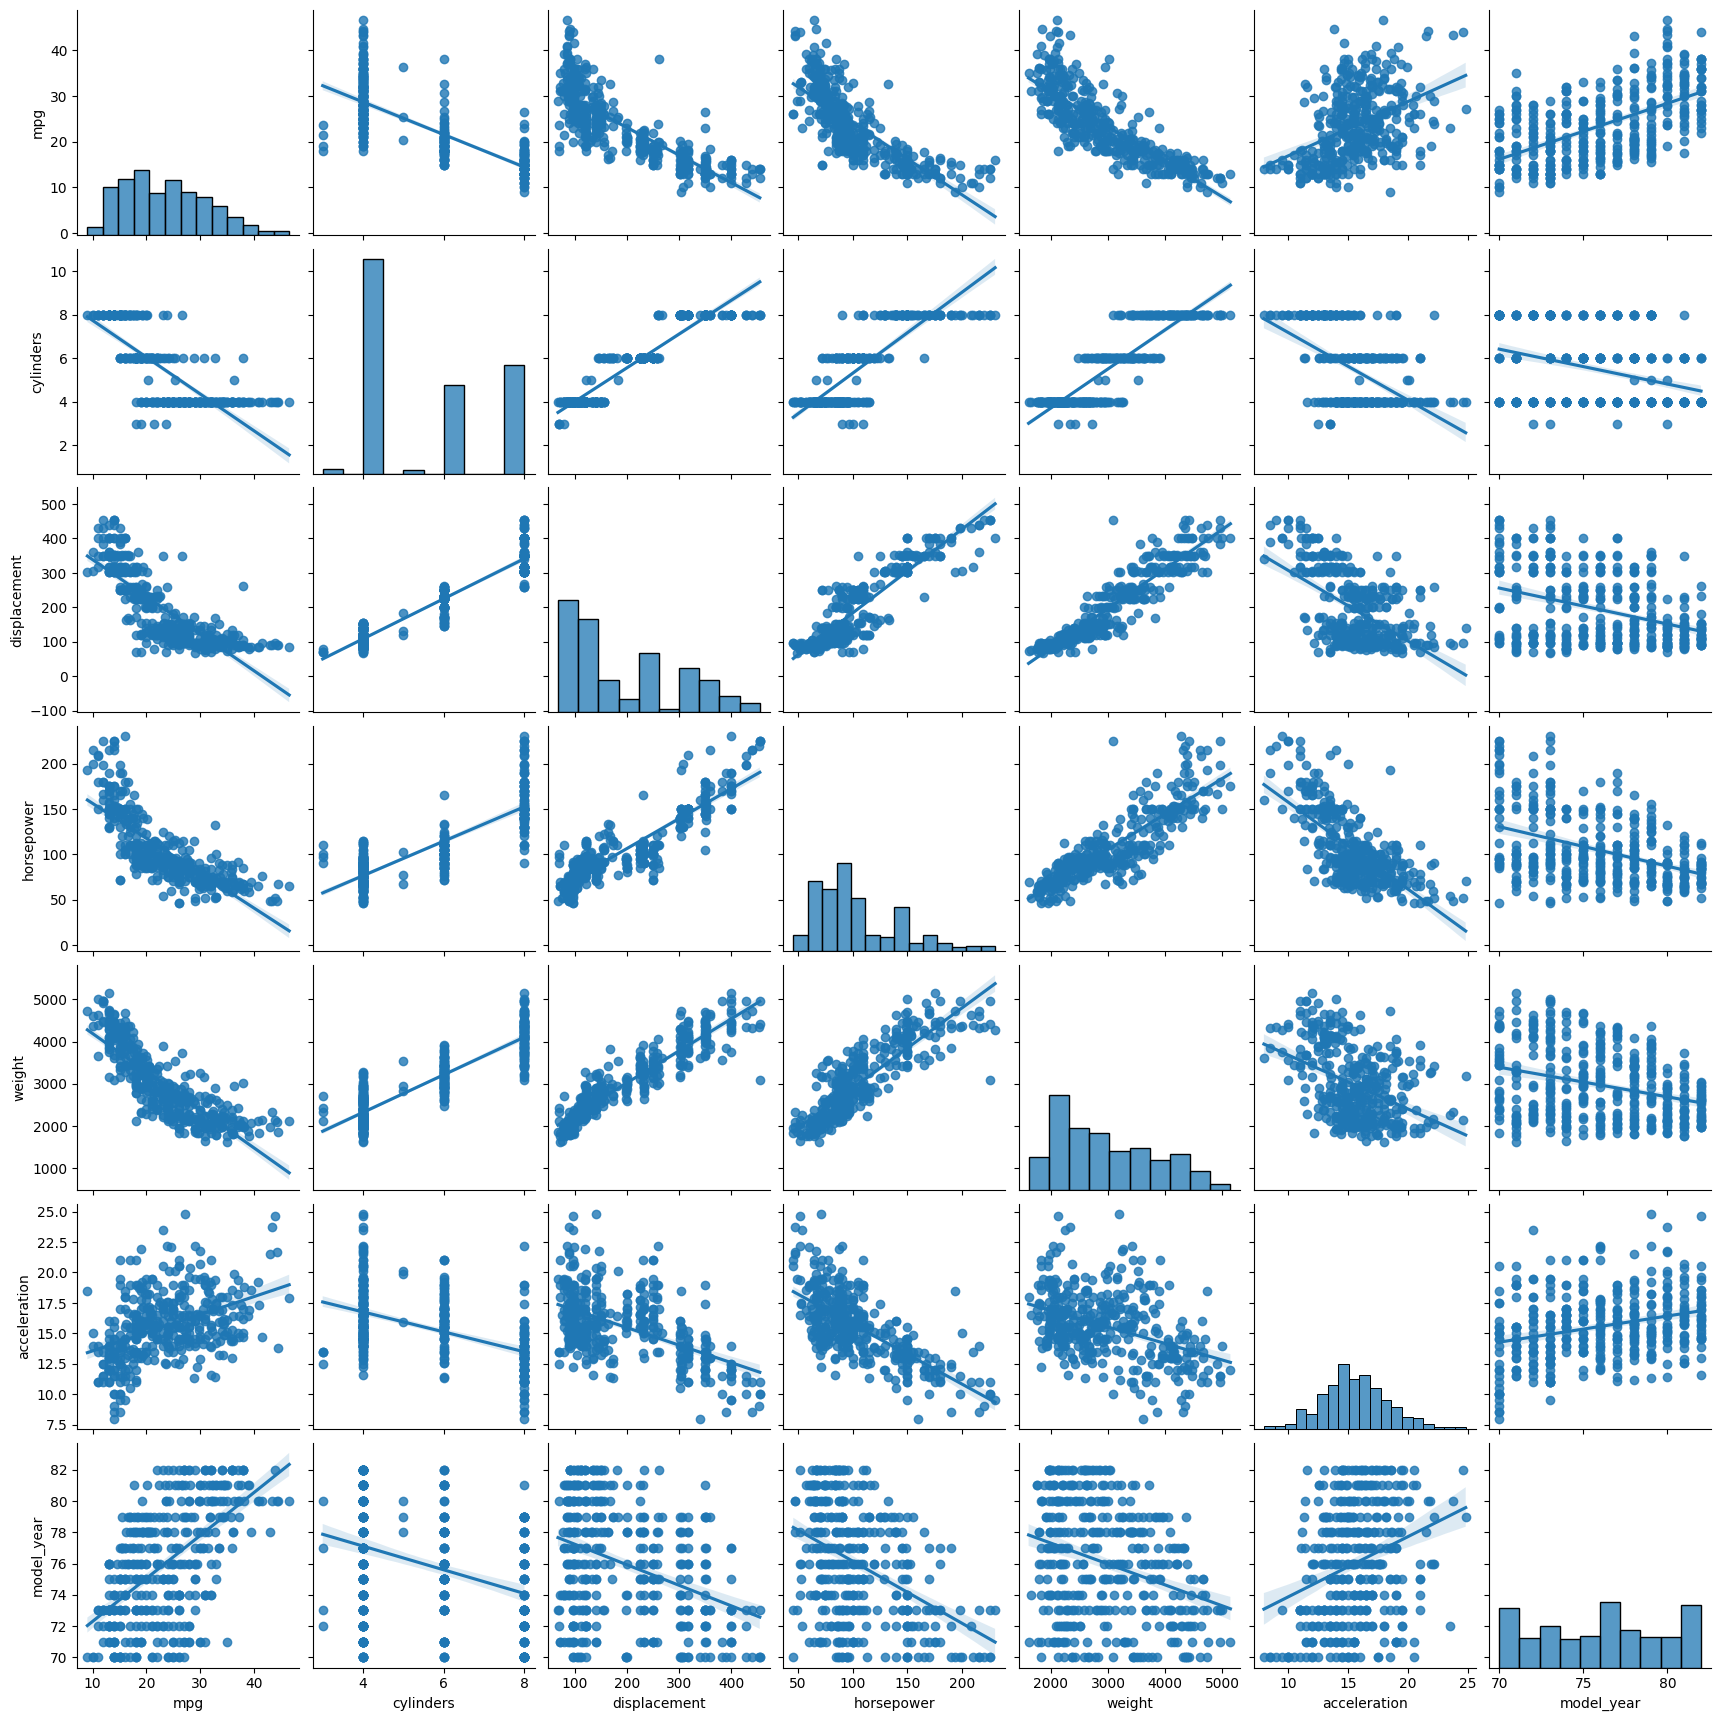

In [9]:
sns.pairplot(dados, kind='reg')

<Axes: >

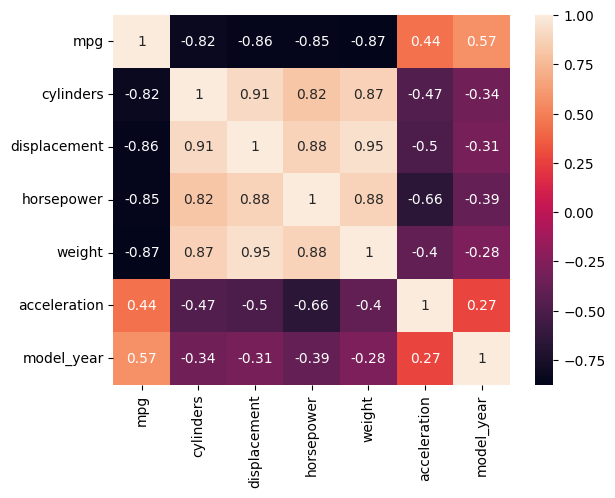

In [10]:
correlacao = dados.select_dtypes(include='number').corr(method='spearman')
sns.heatmap(correlacao, annot=True)

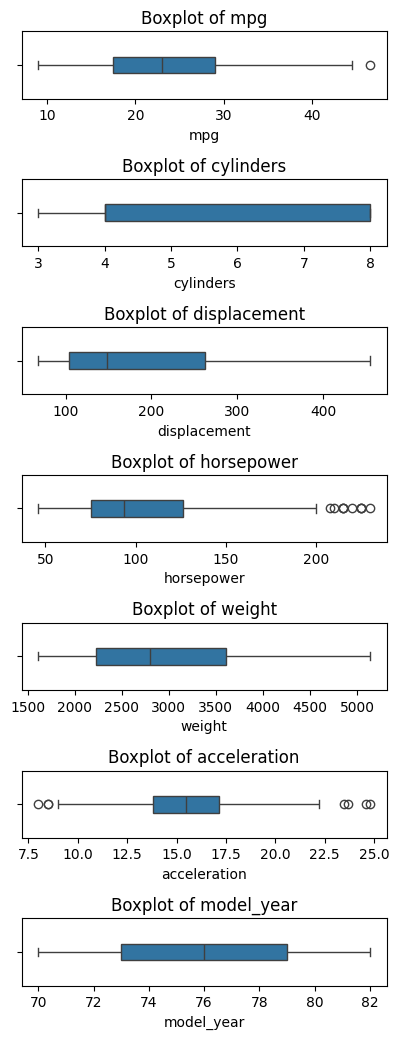

In [11]:
# Filtra colunas numéricas
num_cols = dados.select_dtypes(include=['number']).columns

# Cria uma figura
plt.figure(figsize=(4, len(num_cols) * 1.5))

# Loop para gerar boxplots
for i, col in enumerate(num_cols):
    plt.subplot(len(num_cols), 1, i + 1)
    sns.boxplot(data=dados, x=col, width=0.25)
    plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

In [12]:
dados.columns

Index(['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'model_year', 'origin'],
      dtype='object')

In [13]:
dados['origin'] = dados['origin'].replace('usa', 0).replace('japan', 1).replace('europe', 2)
dados.drop(['weight', 'displacement'], axis=1, inplace=True)

In [14]:
dados.head()

,mpg,cylinders,horsepower,acceleration,model_year,origin
0,18.0,8,130.0,12.0,70,0
1,15.0,8,165.0,11.5,70,0
2,18.0,8,150.0,11.0,70,0
3,16.0,8,150.0,12.0,70,0
4,17.0,8,140.0,10.5,70,0


In [15]:
dados.isna().sum()

,0
mpg,0
cylinders,0
horsepower,6
acceleration,0
model_year,0
origin,0


In [16]:
dados.dropna(axis=0, inplace=True)

In [17]:
dados.shape

(392, 6)

## **Modelagem**

In [18]:
x = dados.drop('mpg', axis=1).to_numpy()
y = dados[['mpg']].to_numpy()


xtreino, xteste, ytreino, yteste = train_test_split(x, y, test_size=0.3, random_state=35)

print(xtreino.shape)
print(xteste.shape)
print(ytreino.shape)
print(yteste.shape)

(274, 5)
(118, 5)
(274, 1)
(118, 1)


In [19]:
# Estrutura da Rede
scaler_x = StandardScaler()
scaler_y = StandardScaler()

xtreino_std = scaler_x.fit_transform(xtreino)
xteste_std = scaler_x.fit_transform(xteste)
ytreino_std = scaler_y.fit_transform(ytreino)
yteste_std = scaler_y.fit_transform(yteste)

In [20]:
rede = keras.Sequential()

# Camada 1:
rede.add(layers.Dense(8,
                input_dim=xtreino_std.shape[1],
                activation='relu')
)

#Saída
rede.add(layers.Dense(1))

# Compilação
rede.compile(loss='mean_squared_error',
                         optimizer=keras.optimizers.RMSprop(),
                         metrics=[tf.keras.metrics.R2Score]
             )

rede.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 8)                   │              48 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 57 (228.00 B)

 Trainable params: 57 (228.00 B)

 Non-trainable params: 0 (0.00 B)

In [21]:
rna_earlystop = keras.callbacks.EarlyStopping(
    monitor="val_r2_score",
    min_delta=0.025,
    patience = 50,
    verbose=1,
    mode='max',
    restore_best_weights=True
)

historico = rede.fit(
    x=xtreino_std,
    y=ytreino_std,
    epochs=250,
    batch_size=16,
    validation_split=0.2,
    callbacks=rna_earlystop
)

Epoch 1/250
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.0695 - r2_score: -0.0625 - val_loss: 1.1446 - val_r2_score: -0.2756
Epoch 2/250
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9071 - r2_score: 0.1782 - val_loss: 0.9982 - val_r2_score: -0.1125
Epoch 3/250
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7797 - r2_score: 0.2399 - val_loss: 0.8752 - val_r2_score: 0.0247
Epoch 4/250
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7247 - r2_score: 0.3131 - val_loss: 0.7735 - val_r2_score: 0.1379
Epoch 5/250
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5272 - r2_score: 0.4563 - val_loss: 0.6772 - val_r2_score: 0.2453
Epoch 6/250
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4802 - r2_score: 0.5481 - val_loss: 0.6048 - val_r2_score: 0.3260
Epoch 7/250
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4376 - r2_score: 0.5005 - val_loss: 0.5398 - val_r2_score: 0.3984
Epoch 8/250
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3357 - r2_score: 0.6737 - val_loss: 0.4907 - v

## **Performance**

In [22]:
score_treino, metric_treino = rede.evaluate(xtreino_std, ytreino_std, verbose=0)
score_teste, metric_teste = rede.evaluate(xteste_std, yteste_std, verbose=0)

print(f'R² no conjunto de treino: {round(metric_treino*100, 1)}%')
print(f'R² no conjunto de teste: {round(metric_teste*100, 1)}%')

R² no conjunto de treino: 84.3%
R² no conjunto de teste: 85.6%


In [23]:
predicoes_teste = scaler_y.inverse_transform(rede.predict(xteste_std))
predicoes_teste[0:5]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


array([[19.4386  ],
       [35.474197],
       [32.441536],
       [13.343633],
       [30.37032 ]], dtype=float32)

Text(0, 0.5, 'Predito')

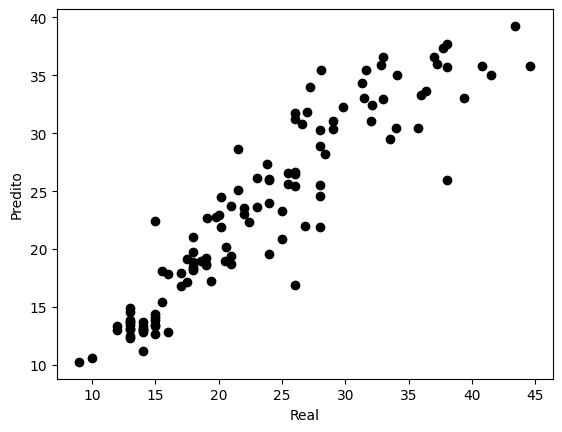

In [24]:
fig, ax = plt.subplots()
yteste_original =  scaler_y.inverse_transform(yteste_std)
plt.plot(yteste_original, predicoes_teste, 'o', color='k')
plt.xlabel('Real')
plt.ylabel('Predito')

In [25]:
historico.history.keys()

dict_keys(['loss', 'r2_score', 'val_loss', 'val_r2_score'])

<ipython-input-26-0efc70ba849a>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1);


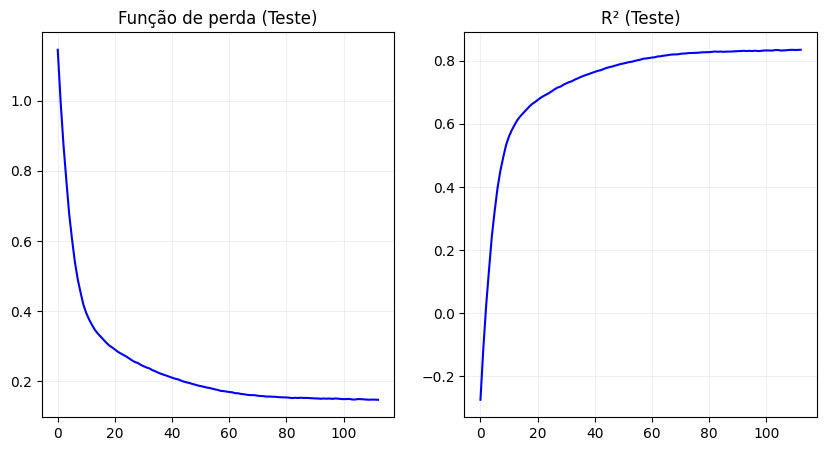

In [26]:
# Validação para o teste:
fig, ax = plt.subplots(figsize=(10,5))
plt.subplot(1,2,1);
plt.title('Função de perda (Teste)');
plt.plot(historico.history['val_loss'], color='blue')
plt.grid(alpha=0.2)

plt.subplot(1,2,2)
plt.title("R² (Teste)")
plt.plot(historico.history['val_r2_score'], color='blue')
plt.grid(alpha=0.2)

* Predições (primeiras cinco observações)

In [27]:
print(f'Valores y (real)\n{yteste_original[0:5]}')
print('---'*10)
print(f'Valores de y (predito)\n{predicoes_teste[0:5]}')

Valores y (real)
[[21. ]
 [31.6]
 [32.1]
 [12. ]
 [29. ]]
------------------------------
Valores de y (predito)
[[19.4386  ]
 [35.474197]
 [32.441536]
 [13.343633]
 [30.37032 ]]


<ipython-input-28-c6d9b42d2efe>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1);


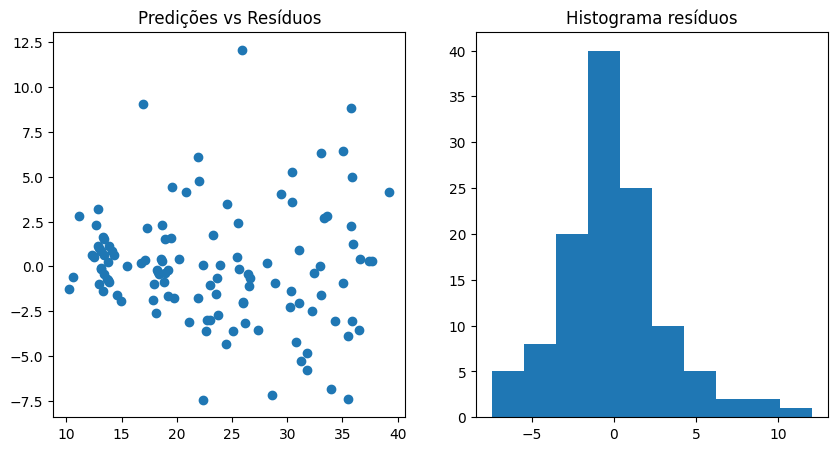

In [28]:
residuo = yteste_original - predicoes_teste

# Validação para o teste:
fig, ax = plt.subplots(figsize=(10,5))
plt.subplot(1,2,1);
plt.title('Predições vs Resíduos');
plt.plot(predicoes_teste, residuo, 'o');
plt.subplot(1,2,2);
plt.title("Histograma resíduos");
plt.hist( residuo);